In [2]:
import pandas as pd

In [6]:
data_train=pd.read_csv("/Users/agishaalbert/Downloads/processed_data1.csv")

data_train.head(5)

,review,sentiment
0,one review ha mention watch 1 Oz episod youll ...,positive
1,wonder littl product film techniqu veri unassu...,positive
2,thought thi wa wonder way spend time hot summe...,positive
3,basic famili littl boy jake think zombi hi clo...,negative
4,petter mattei love time money visual stun film...,positive


In [11]:
sent = pd.Series(np.where(data_train.sentiment.values == 'positive',1,0))

In [12]:
data_train["sentiment"]=sent

In [13]:
data_train.head(5)

,review,sentiment
0,one review ha mention watch 1 Oz episod youll ...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


In [17]:
# def preprocess(data):
#     data = convert_lower_case(data)
#     data = remove_punctuation(data)
#     data = remove_apostrophe(data)
#     data = remove_single_characters(data)
#     data = convert_numbers(data)
#     data = remove_stop_words(data)
#     data = stemming(data)
#     data = remove_punctuation(data)
#     data = convert_numbers(data)

In [20]:
# DF = {}
# for i in range(len(data_train.review)):
#     tokens = data_train.review[i]
#     for w in tokens:
#         try:
#             DF[w].add(i)
#         except:
#             DF[w] = {i}
# len(DF)

In [21]:
# for i in DF:
#     DF[i]=len(DF[i])
# len(DF)

In [23]:
# Input : set of documents
# Output: word, dimension number pair for each word as a python dictionary
def fit_custom(dataset):
  unique_words = []
  for row in dataset:
    for word in row.split(" "):
      if len(word)>=2 and word not in unique_words:
        unique_words.append(word) # Add each unique word of length>2 to the list
  unique_words.sort()
  word_dimension_dict = {j:i for i,j in enumerate(unique_words)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
  return word_dimension_dict

word_dimension_dict = fit_custom(data_train.review)
# print(word_dimension_dict)

In [24]:
# Defining an utility Function to calculate the number of times a word appears in a whole dataset
def count_of_word_in_whole_dataset(dataset, word):
  count = 0
  for row in dataset:
    if word in row:
      count = count+1
  return count

In [25]:
# TRANSFROM METHOD
# Input : set of documents, word_dimension_dict from fit_custom() ; Output : TF-count_of_word_in_whole_dataset Matrix
def transform_custom(dataset, word_dimension_dict):
  rows = []
  columns = []
  values = []
  tf_val = []
  idf_val = []
  for idx, row in enumerate(dataset): # for each document in the dataset
    # it will return a dict type object where key is the word and values is its frequency, {word:frequency}
    word_freq = dict(Counter(row.split()))
    # for every unique word in the document
    for word, freq in word_freq.items():
      if len(word) < 2:
        continue
      # we will check if its there in the word_dimension_dictionary that we build in fit_custom() function
      # dict.get() function will return the values, if the key doesn't exits it will return -1
      col_index = word_dimension_dict.get(word, -1) # retrieving the dimension number of a word
      if col_index!=-1:
        # we are storing the index of the document
        rows.append(idx)
        # we are storing the dimensions of the word
        columns.append(col_index)
        # computes TF value for each word, freq of each word / total words in a document
        # computes count_of_word_in_whole_dataset value for each word=log(total no. of docus / no. of times a word is present in a doc via count_of_word_in_whole_dataset()

        # Now just multiply TF with count_of_word_in_whole_dataset
        # Below formulae to exactly replicate sklearn's formulae for tf-df calculation
        # See - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
        # If ``smooth_idf=True`` (the default), the constant "1" is added to the
        # numerator and denominator of the idf as if an extra document was seen
        # containing every term in the collection exactly once, which prevents
        # zero divisions: idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1.
        # https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L1340
        tf_idf_value = (freq/len(row.split()))*(1 + (  np.log( (1 + len(dataset) ) / (1 + count_of_word_in_whole_dataset(dataset, word) ))))

        # but if smooth_idf=False then the following formulae would have been applied
        # val = (freq/len(row.split()))*(1 + (  np.log( (int(len(dataset)) ) / (count_of_word_in_whole_dataset(dataset, word) ))))

        values.append(tf_idf_value)

        sparse_matrix = csr_matrix((values, (rows,columns)), shape=(len(dataset), len(word_dimension_dict)))

        # As noted earlier, in sk-learn this output is normalized using L2 normalization. sklearn does this by default.
        # So we have to do that as well to match with sk-learn
        # normalize() function will apply ‘l2’, normalization by default
        # The 'norm' parameter to use to normalize each non zero sample
        # (or each non-zero feature if axis is 0).
        # https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
        final_normalized_output = normalize(sparse_matrix)

  return final_normalized_output

In [30]:
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random


In [ ]:
tf_idf_vectorized_custom = transform_custom(data_train.review, word_dimension_dict)

# As the final output of sklearn tf-idf vectorizer is a sparse matrix to save storage space
# To visually understand the output better, we need to convert the sparse output matrix to dense matrix with toarray()
print(tf_idf_vectorized_custom.toarray())

# Even more clear way to visually inspect the output is to convert it to a pandas dataframe
# So below I will convert that to a dataframe and then use todense()
custom_tf_idf_output = tf_idf_vectorized_custom[0]
df_custom_tf_idf = pd.DataFrame(custom_tf_idf_output.T.todense(),  index=word_dimension_dict.keys(), columns=['tf-idf'])
df_custom_tf_idf.sort_values(by=["tf-idf"], ascending=True)
df_custom_tf_idf.head(5)


[0.58977016 0.17946483] -0.1520000000000001


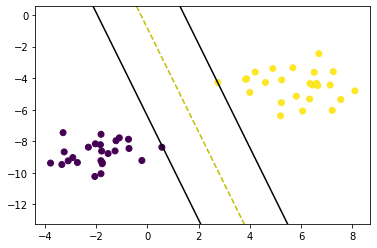

In [1]:
import numpy as np


class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)


# Testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    import matplotlib.pyplot as plt

    X, y = datasets.make_blobs(
        n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
    )
    y = np.where(y == 0, -1, 1)

    clf = SVM()
    clf.fit(X, y)
    # predictions = clf.predict(X)

    print(clf.w, clf.b)

    def visualize_svm():
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])

        x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
        x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

        x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
        x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

        x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
        x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])

        plt.show()

    visualize_svm()